In [9]:
import cv2
import pydicom
import numpy as np

test_img = cv2.imread("dataset/muryadi 9-img-00001-00001 (1).bmp")

In [2]:
def read_dcm_images(img_path: str) -> np.array:
    dcm_file = pydicom.read_file(img_path)
    return dcm_file.pixel_array

In [3]:
import cv2
import matplotlib.pyplot as plt

def plot_img(img, title="Image", cmap="gray"):
    """Plots an image using OpenCV and Matplotlib.

    Args:
        img: OpenCV image (grayscale or color).
        title: Optional title for the plot.
        cmap: Optional colormap for grayscale images.
    """

    # Convert BGR to RGB if necessary
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create the plot using Matplotlib
    plt.figure(figsize=(8, 6))  # Set a default figure size
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")  # Remove axis labels
    plt.show()

muryadi 10-img-00001-00001 (1)


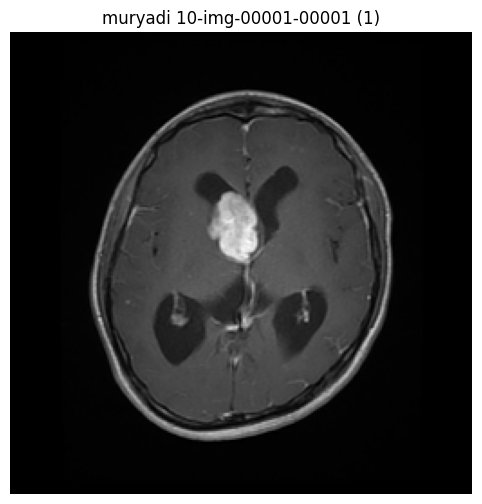

SAADAH 14-dicom-00001 (1)


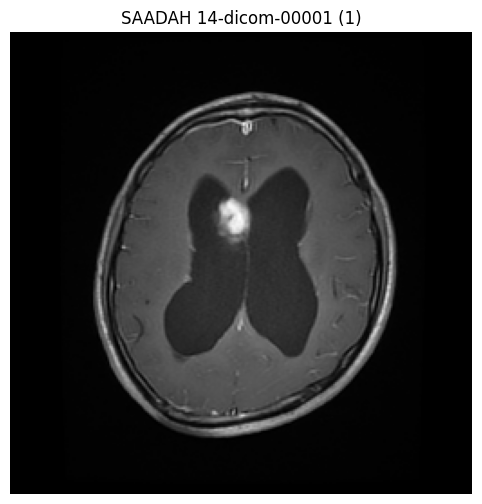

SAADAH 9-dicom-00001 (1)


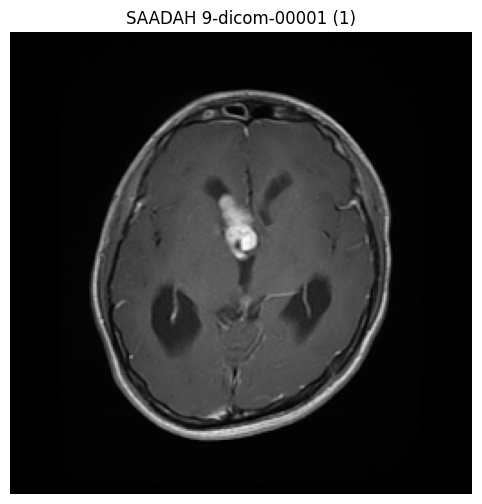

SAADAH 13-dicom-00001 (1)


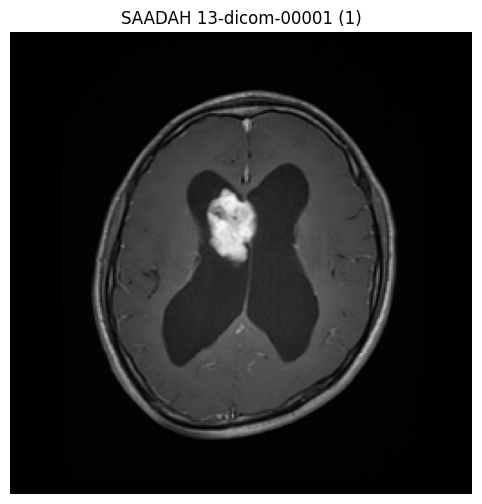

SAADAH 12-dicom-00001 (1)


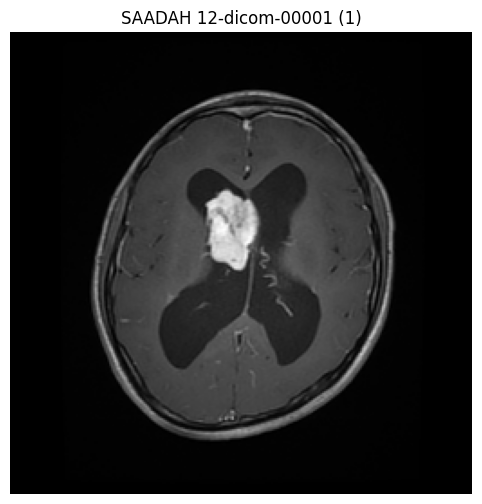

muryadi 11-img-00001-00001 (1)


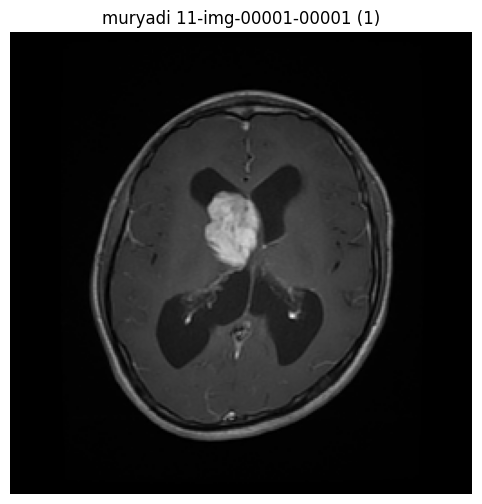

muryadi 9-img-00001-00001 (1)


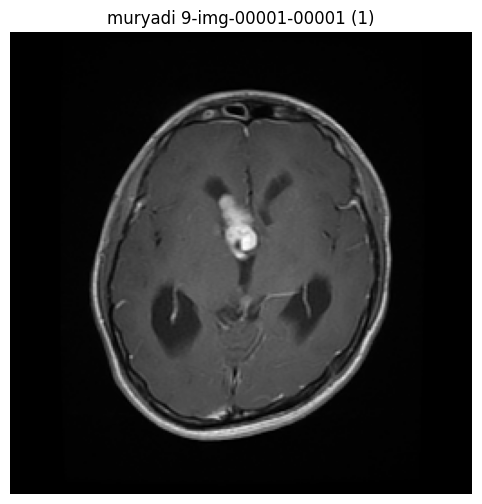

SAADAH 11-dicom-00001 (1)


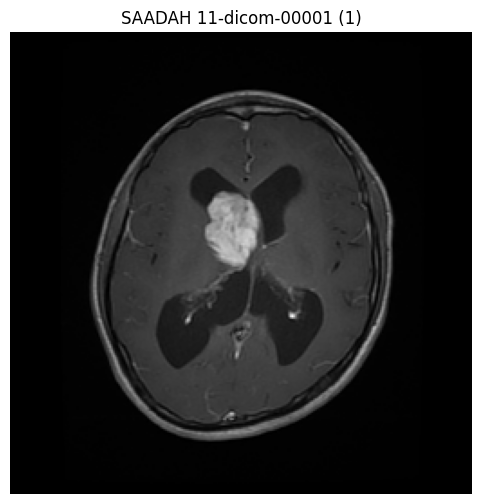

muryadi 12-img-00001-00001 (1)


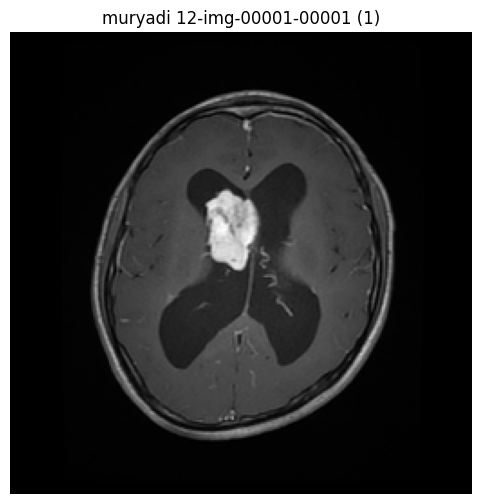

SAADAH 10-dicom-00001 (1)


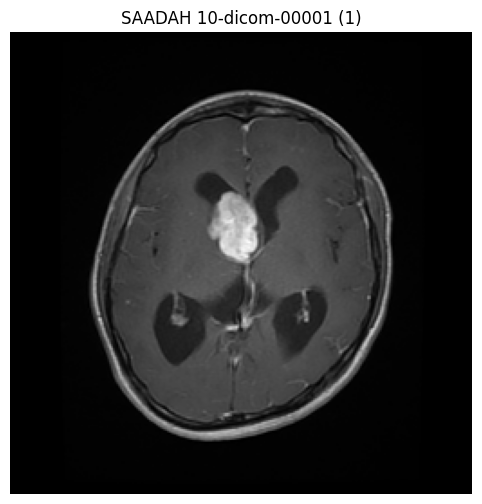

muryadi 14-img-00001-00001 (1)


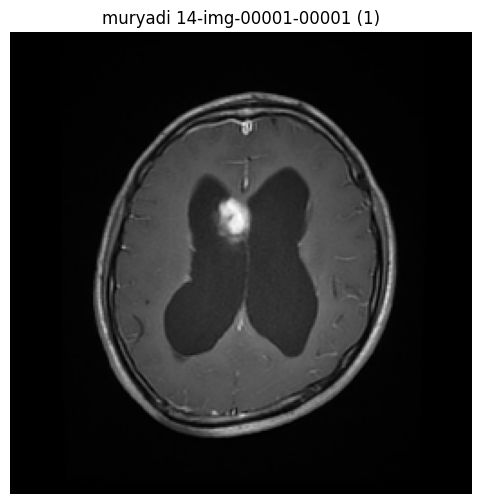

In [4]:
import glob
import os

DATASET_DIR = "dataset/"
list_read_img = []

for img_path in glob.glob(os.path.join(DATASET_DIR,"*")):
    img_ext = img_path.split(".")[-1]
    img_name = os.path.split(img_path)[-1].split(".")[0]
    print(img_name)
    img = None
    if img_ext == "dcm":
        img = read_dcm_images(img_path)
    else:
        img = cv2.imread(img_path)
    list_read_img.append(img)
    plot_img(img, title=img_name)

## Image Segmentation using Otsu Thresholding

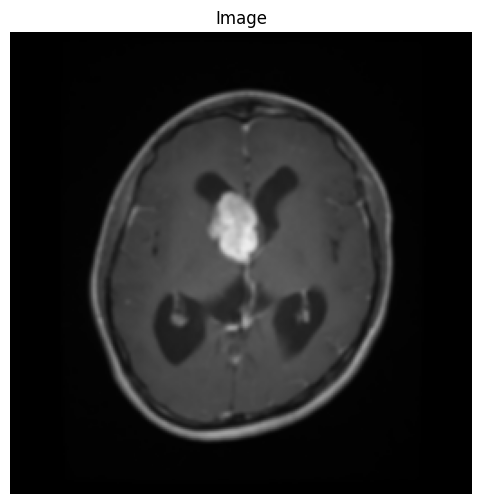

In [5]:
# # reduce noise using gaussian blur
# list_reduced_noise_imgs = []
# for img in list_read_img:
#     new_img = cv2.GaussianBlur(img, (5, 5), 0)
#     plot_img(new_img)

In [5]:
def find_otsu_thresholding(image, is_normalized=False, bins_num=256):
    # Get the image histogram
    hist, bin_edges = np.histogram(image, bins=bins_num)
    
    # Get normalized histogram if it is required
    if is_normalized:
        hist = np.divide(hist.ravel(), hist.max())
    
    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.
    
    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    
    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
    
    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    
    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)
    
    threshold = bin_mids[:-1][index_of_max_val]
    return threshold

In [113]:
mean_otsu_thresholding = []

for img in list_read_img:
    mean_otsu_thresholding.append(find_otsu_thresholding(img, is_normalized=True))

mean_otsu_thresholding = sum(mean_otsu_thresholding) / len(mean_otsu_thresholding)

print(mean_otsu_thresholding)

40.16068892045455


In [164]:
# Create a mask to exclude black pixels
mask = (test_img > 5).astype(np.uint8) * 255

plot_img()

error: OpenCV(4.8.1) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


In [199]:
def image_segmentation_using_otsu_threshold(image, offset=110):
    if len(image.shape) > 2:
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    mask = (image > 5).astype(np.uint8) * 255

    # otsu thresholding
    otsu_threshold = find_otsu_thresholding(image)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(image, offset + otsu_threshold, 255, cv2.THRESH_BINARY)
    print(otsu_threshold)
    segmented_image = cv2.bitwise_and(segmented_image, segmented_image, mask)
    return segmented_image

In [186]:
def predict_tumor_segmentation(image):
    # Background Extraction.
    print("First otsu threhsold iteration")
    segmented_image = image_segmentation_using_otsu_threshold(image)

    # Try another otsu segmentation
    new_img = cv2.bitwise_and(image, image, mask=segmented_image)

    return image_segmentation_using_otsu_threshold(new_img)

In [200]:
segmented_image = image_segmentation_using_otsu_threshold(test_img)

43.330078125


In [201]:
predicted_mask = predict_tumor_segmentation(test_img)

First otsu threhsold iteration
43.330078125
0.498046875


41.337890625


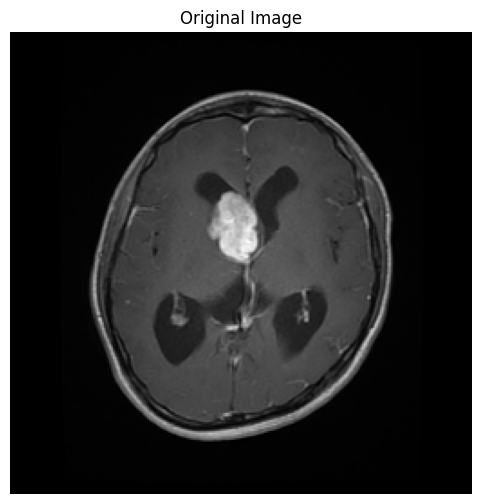

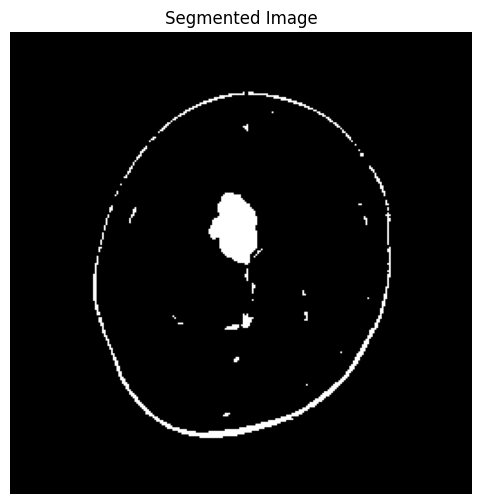

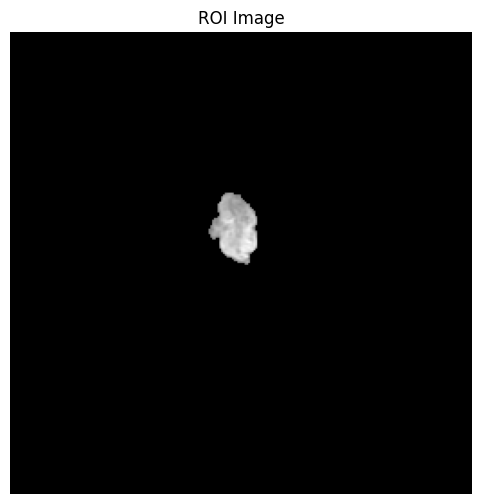

41.337890625


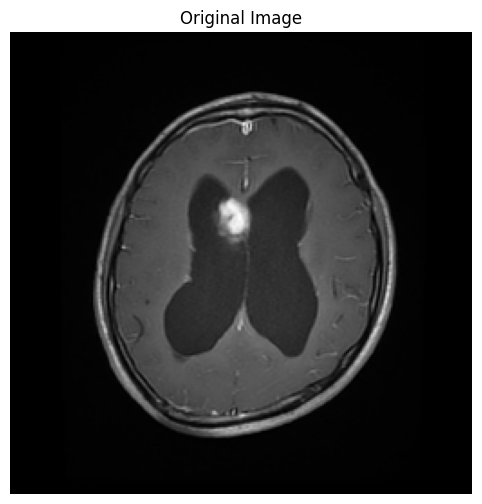

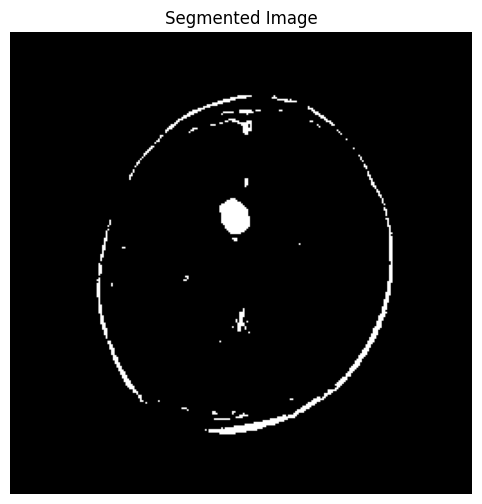

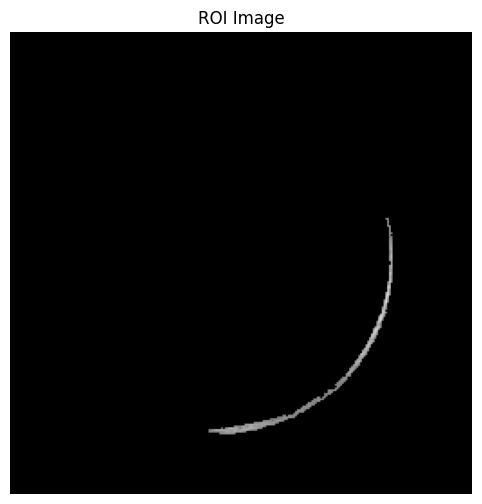

43.330078125


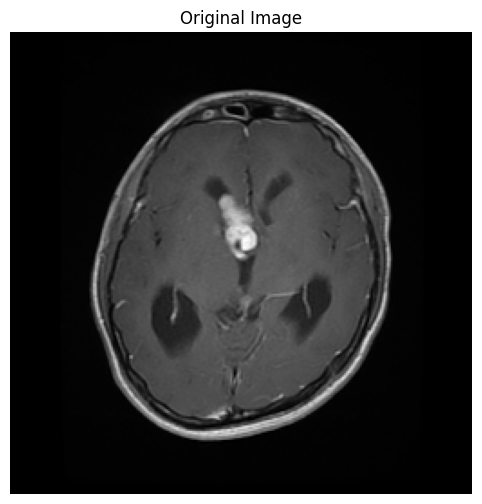

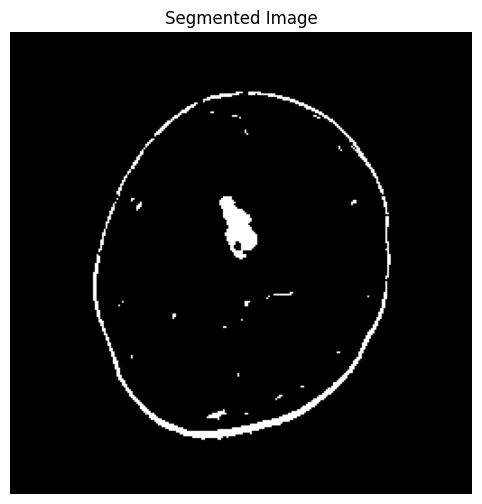

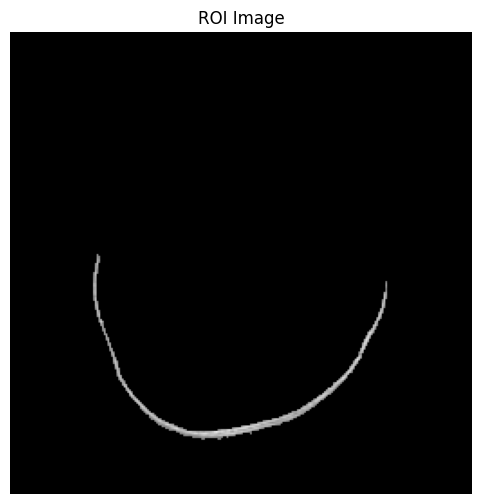

38.349609375


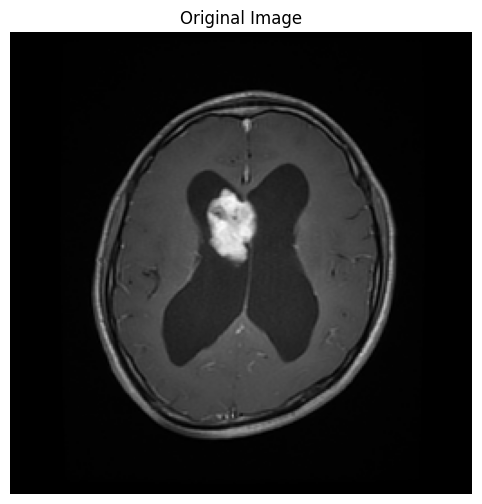

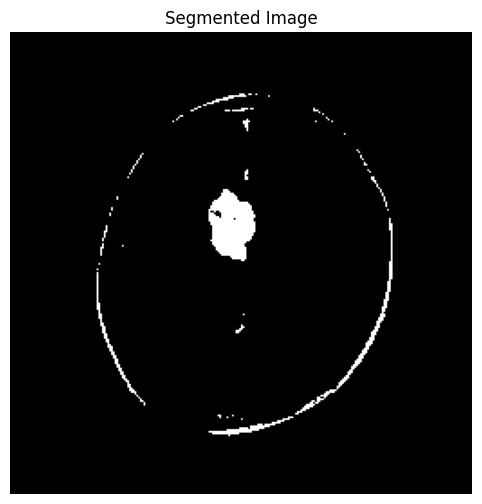

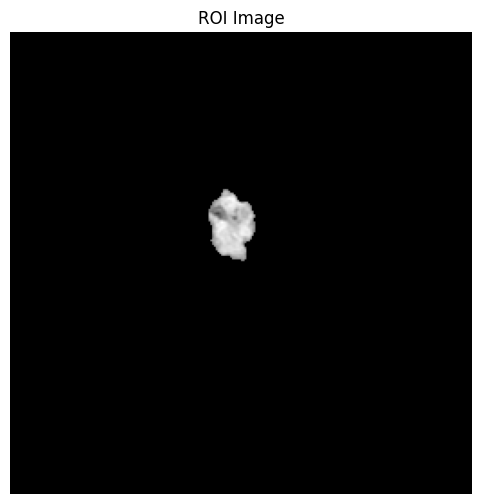

40.341796875


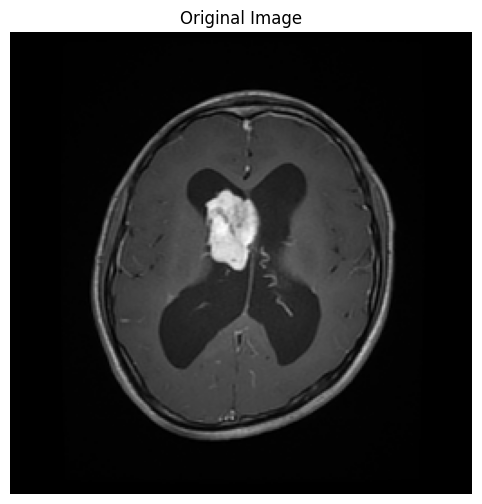

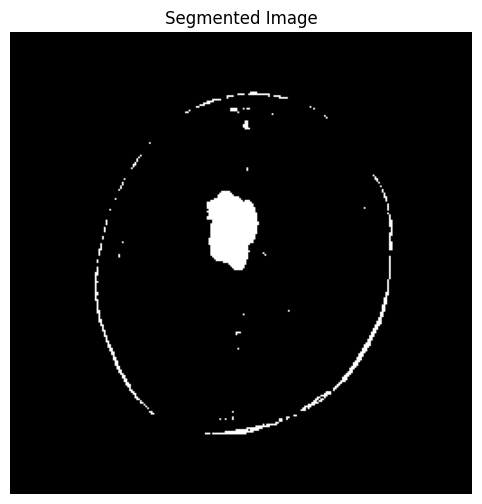

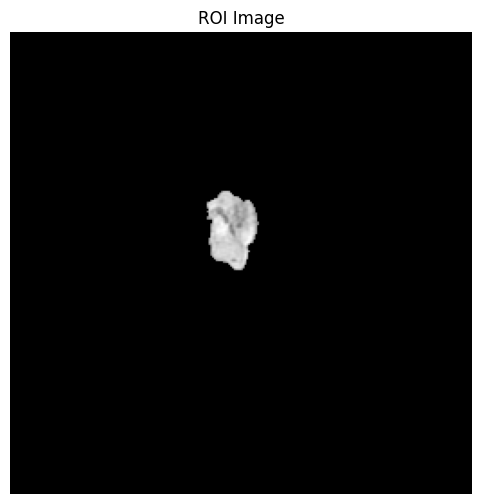

35.361328125


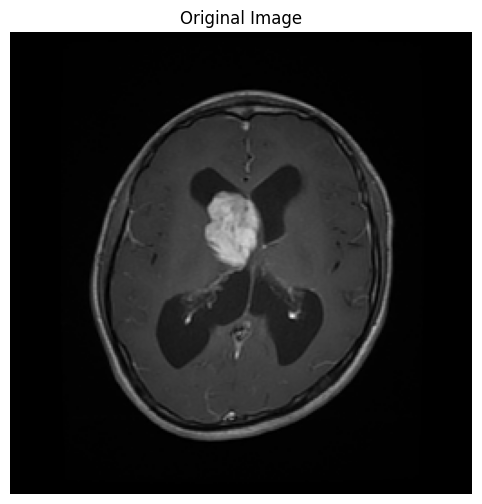

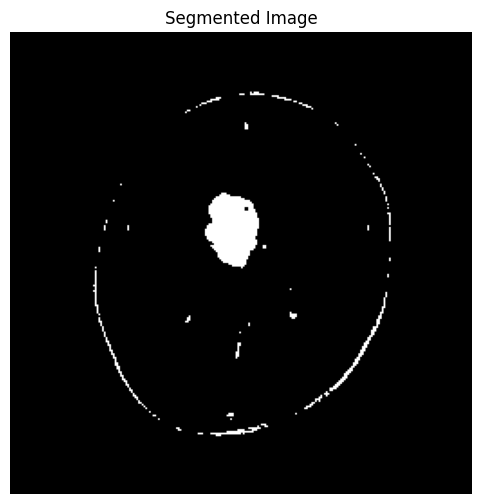

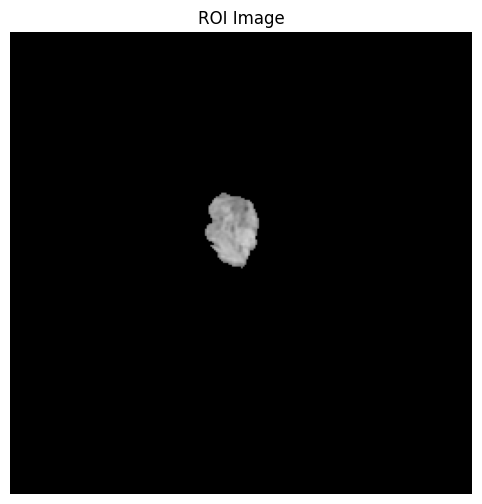

43.330078125


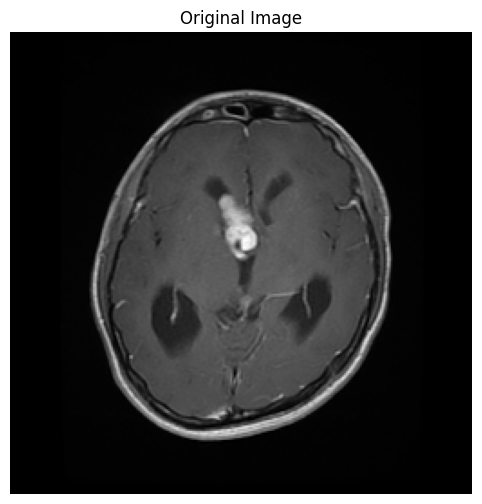

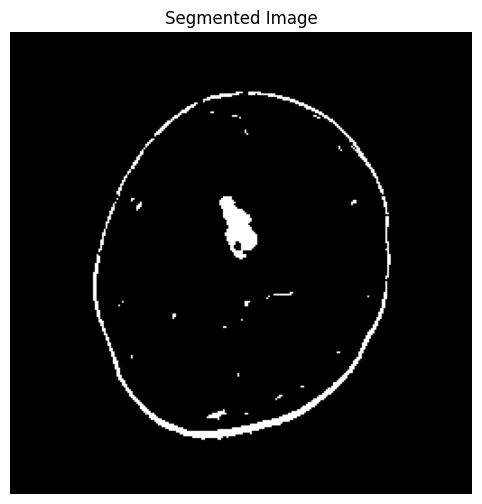

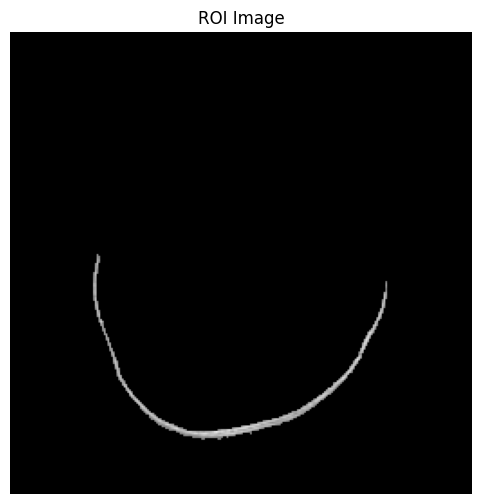

35.361328125


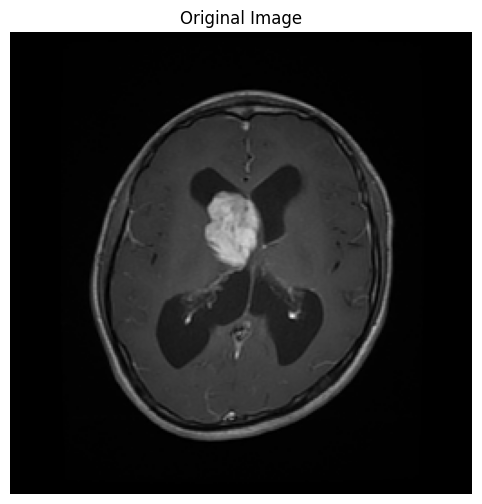

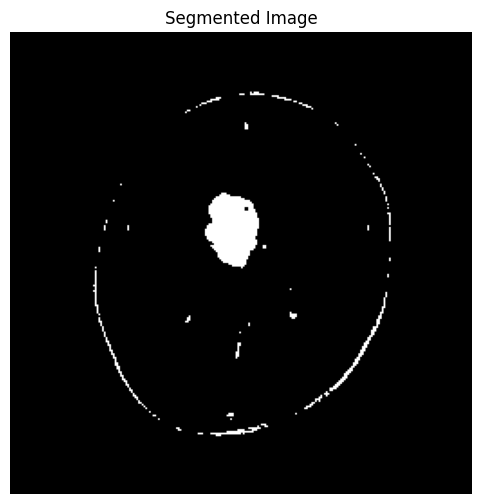

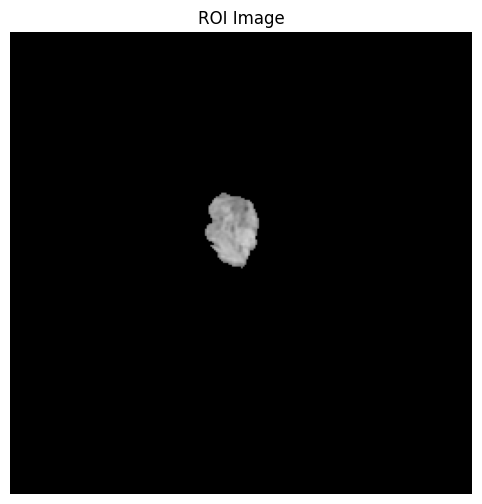

40.341796875


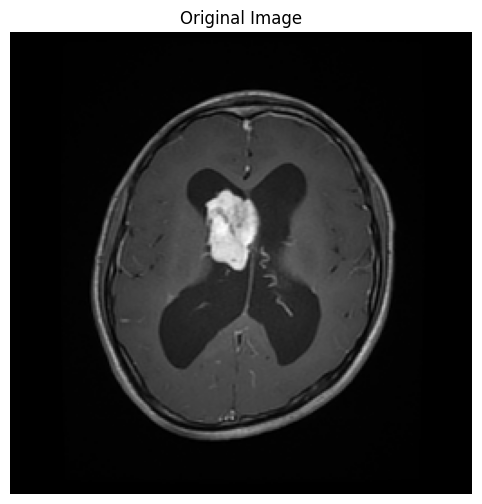

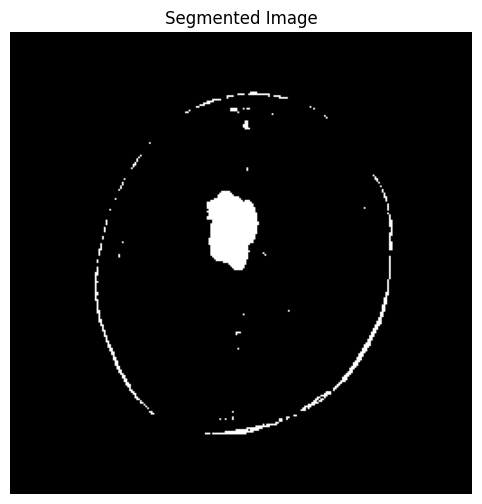

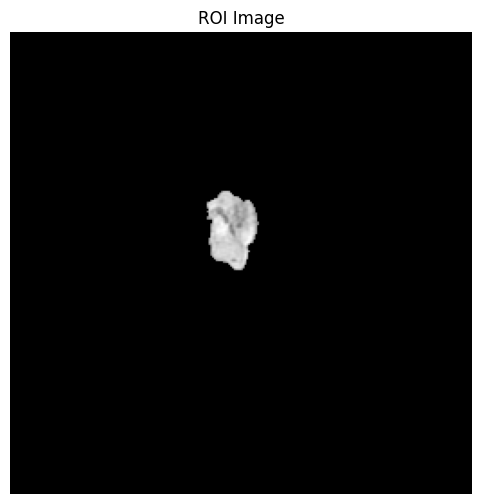

41.337890625


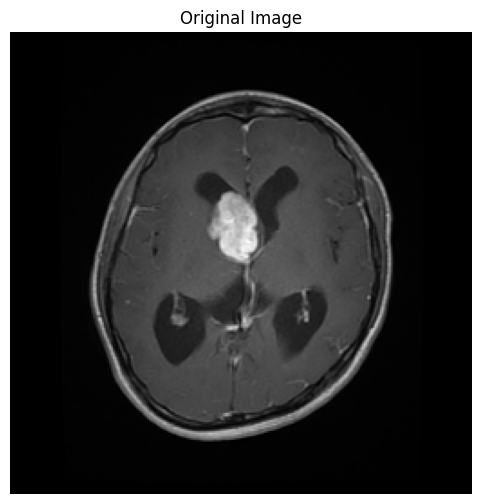

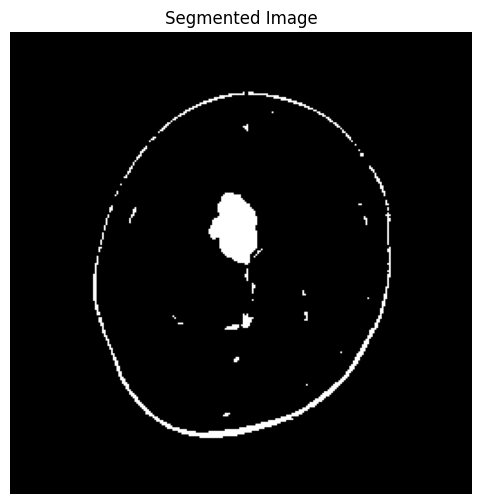

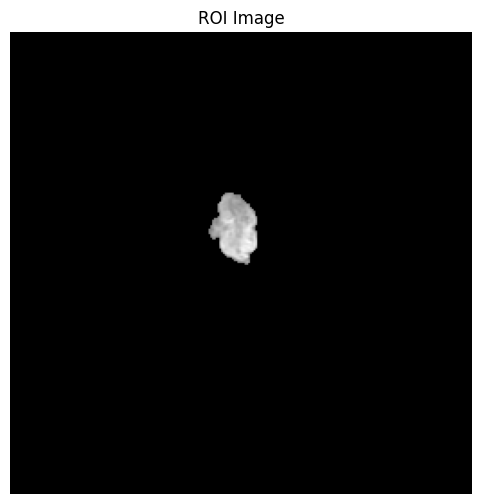

41.337890625


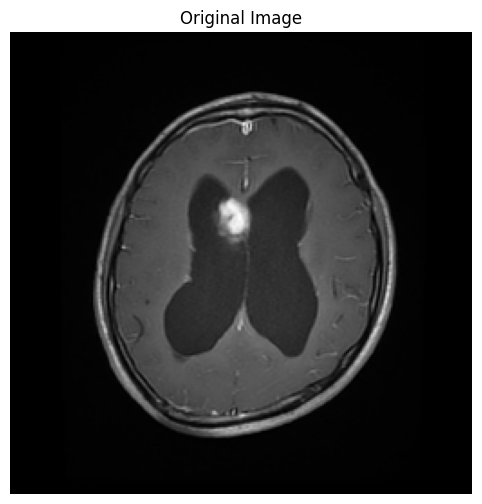

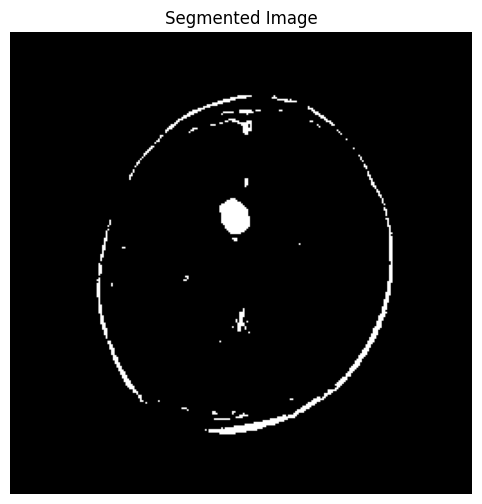

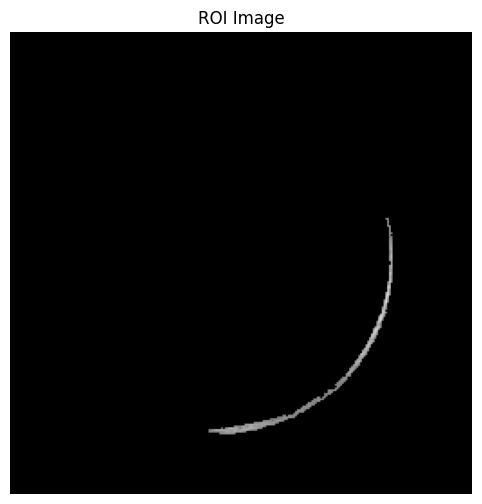

In [209]:
for img in list_read_img:
    segmented_image = image_segmentation_using_otsu_threshold(img, offset=80)

    roi_image = cv2.bitwise_and(img, img, mask=segmented_image)
    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # print(contours)
    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)
    # print(largest_contour)

    # Create an empty mask to draw the largest contour
    largest_contour_mask = np.zeros_like(segmented_image)
    cv2.drawContours(largest_contour_mask, [largest_contour], 0, 255, thickness=cv2.FILLED)

    # Extract the largest region from the original image
    largest_region = cv2.bitwise_and(img, img, mask=largest_contour_mask)

    plot_img(img, title="Original Image")
    plot_img(segmented_image, title="Segmented Image")
    plot_img(largest_region, title="ROI Image")

In [205]:


# Find contours in the segmented image
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the largest area
largest_contour = max(contours, key=cv2.contourArea)

# Create an empty mask to draw the largest contour
largest_contour_mask = np.zeros_like(segmented_image)
cv2.drawContours(largest_contour_mask, [largest_contour], 0, 255, thickness=cv2.FILLED)

# Extract the largest region from the original image
largest_region = cv2.bitwise_and(image, image, mask=largest_contour_mask)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)